# Prediction of Maternal mortality causes in Ethiopia

## Multiclass classification 

In [1]:
#importing of necessary libraries

import pandas as pd  
import numpy as np  
import seaborn as sns 
import pyreadstat 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from imblearn.over_sampling import SMOTE

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score


from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import time as time

import warnings
warnings.filterwarnings("ignore")

data importing 

In [2]:
df = pd.read_csv("../data/modeling_data.csv", index_col= False)

In [3]:
df

,Age,Parity of index pregnanacy,Complications in previous pregnancy,Refered,Pretreatment pulse,Conscious,Estimate bloodloss,Cause pph,Was labor augmented,Complications index preg,...,Kebele_zeyse,Kebele_ziban gedena kebele,Kebele_zigem,Kebele_zigiti,Kebele_ziguara,Kebele_zihibest,Kebele_zilan amistya,Kebele_zone 3,Kebele_zone 4,Unnamed: 29_XY from 2016 EmONC Assessment
0,25.0,3.0,0.0,0.0,84.0,1.0,9999.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,20.0,1.0,0.0,0.0,100.0,1.0,9999.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,25.0,1.0,88.0,0.0,75.0,1.0,9999.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,26.0,4.0,88.0,0.0,90.0,1.0,9999.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,27.0,3.0,88.0,0.0,84.0,1.0,9999.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7603,30.0,1.0,0.0,0.0,80.0,1.0,9999.0,3.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7604,24.0,1.0,0.0,0.0,76.0,1.0,9999.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7605,28.0,3.0,0.0,1.0,85.0,1.0,9999.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7606,40.0,2.0,0.0,1.0,108.0,1.0,9999.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7608 entries, 0 to 7607
Columns: 14346 entries, Age to Unnamed: 29_XY from 2016 EmONC Assessment
dtypes: float64(14346)
memory usage: 832.7 MB


In [5]:
df.isnull().sum()

Age                                          0
Parity of index pregnanacy                   0
Complications in previous pregnancy          0
Refered                                      0
Pretreatment pulse                           0
                                            ..
Kebele_zihibest                              0
Kebele_zilan amistya                         0
Kebele_zone 3                                0
Kebele_zone 4                                0
Unnamed: 29_XY from 2016 EmONC Assessment    0
Length: 14346, dtype: int64

In [6]:
# Impute missing values with the mean of each column
df = df.fillna(df.mean())

In [7]:
# Define your feature columns (example given, excluding the target column 'Cause pph')
feature_columns = ['Age', 'Parity of index pregnanacy','Complications in previous pregnancy', 'Refered', 
                   'Pretreatment pulse','Conscious', 'Estimate bloodloss', 'Cause pph', 'Was labor augmented',
                     'Complications index preg', 'Mode of delivery', 'Episiotomy','Fluid given', 'Cross matching',
                       'Fluid intake', 'Uterotonic','Type of Uterotonic', 'Bimanual', 'Manual removal', 'Uterine ballon',
                       'Non Pneumatic', 'Uterine curettage', 'Laparotomy', 'Blood transfusion','Newborn outcome',
                       'Region/Province']

In [8]:
df = df[feature_columns]
df

,Age,Parity of index pregnanacy,Complications in previous pregnancy,Refered,Pretreatment pulse,Conscious,Estimate bloodloss,Cause pph,Was labor augmented,Complications index preg,...,Type of Uterotonic,Bimanual,Manual removal,Uterine ballon,Non Pneumatic,Uterine curettage,Laparotomy,Blood transfusion,Newborn outcome,Region/Province
0,25.0,3.0,0.0,0.0,84.0,1.0,9999.0,3.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,700.0,1.0,7.0
1,20.0,1.0,0.0,0.0,100.0,1.0,9999.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,25.0,1.0,88.0,0.0,75.0,1.0,9999.0,2.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,26.0,4.0,88.0,0.0,90.0,1.0,9999.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,27.0,3.0,88.0,0.0,84.0,1.0,9999.0,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7603,30.0,1.0,0.0,0.0,80.0,1.0,9999.0,3.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0
7604,24.0,1.0,0.0,0.0,76.0,1.0,9999.0,2.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0
7605,28.0,3.0,0.0,1.0,85.0,1.0,9999.0,3.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,700.0,1.0,14.0
7606,40.0,2.0,0.0,1.0,108.0,1.0,9999.0,2.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7608 entries, 0 to 7607
Data columns (total 26 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Age                                  7608 non-null   float64
 1   Parity of index pregnanacy           7608 non-null   float64
 2   Complications in previous pregnancy  7608 non-null   float64
 3   Refered                              7608 non-null   float64
 4   Pretreatment pulse                   7608 non-null   float64
 5   Conscious                            7608 non-null   float64
 6   Estimate bloodloss                   7608 non-null   float64
 7   Cause pph                            7608 non-null   float64
 8   Was labor augmented                  7608 non-null   float64
 9   Complications index preg             7608 non-null   float64
 10  Mode of delivery                     7608 non-null   float64
 11  Episiotomy                    

In [10]:
df.isnull().sum()

Age                                    0
Parity of index pregnanacy             0
Complications in previous pregnancy    0
Refered                                0
Pretreatment pulse                     0
Conscious                              0
Estimate bloodloss                     0
Cause pph                              0
Was labor augmented                    0
Complications index preg               0
Mode of delivery                       0
Episiotomy                             0
Fluid given                            0
Cross matching                         0
Fluid intake                           0
Uterotonic                             0
Type of Uterotonic                     0
Bimanual                               0
Manual removal                         0
Uterine ballon                         0
Non Pneumatic                          0
Uterine curettage                      0
Laparotomy                             0
Blood transfusion                      0
Newborn outcome 

Features and target variable

In [11]:
# Separate features and target variable
target_column = 'Cause pph'
X = df.drop(target_column, axis=1)  # Features
y = df[target_column]               # Target variable

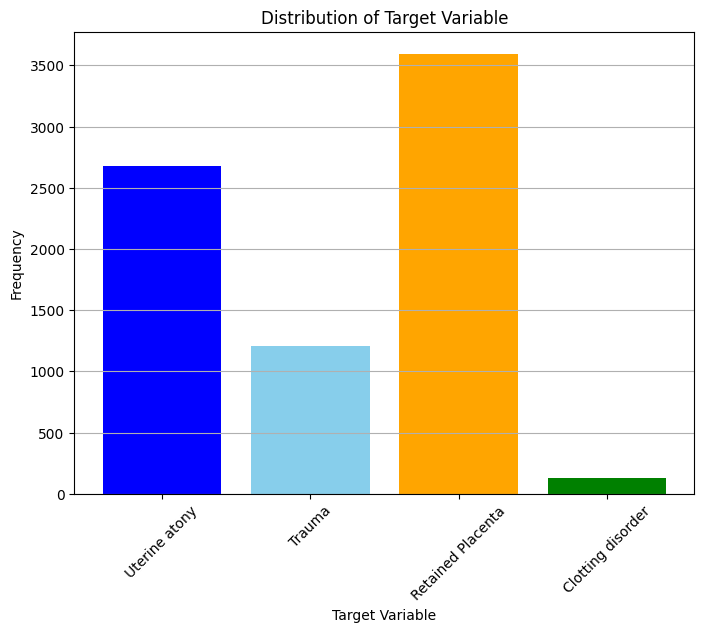

In [12]:
class_names = ['Uterine atony','Trauma','Retained Placenta','Clotting disorder'] 

# Define colors for each class
colors = ['blue', 'skyblue', 'orange', 'green']

# Count frequencies of each class
unique_classes, class_counts = np.unique(y, return_counts=True)

# Plot the bar graph with different colors
plt.figure(figsize=(8, 6))
plt.bar(class_names, class_counts, color=colors)

plt.xlabel('Target Variable')
plt.ylabel('Frequency')
plt.title('Distribution of Target Variable')
plt.grid(axis='y')
plt.xticks(rotation=45)  # Rotate class names for better readability
plt.show()

## Apply sythetic minority over sampling

In [13]:
# Apply SMOTE to balance the dataset class variables 
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

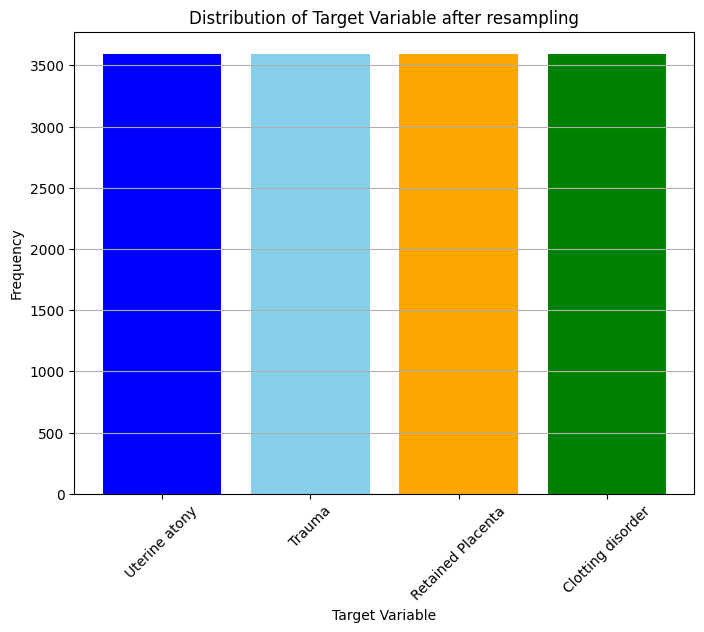

In [14]:
# Define colors for each class
colors = ['blue', 'skyblue', 'orange', 'green']

# Count frequencies of each class
unique_classes, class_counts = np.unique(y_resampled, return_counts=True)

# Plot the bar graph with different colors
plt.figure(figsize=(8, 6))
plt.bar(class_names, class_counts, color=colors)

plt.xlabel('Target Variable')
plt.ylabel('Frequency')
plt.title('Distribution of Target Variable after resampling')
plt.grid(axis='y')
plt.xticks(rotation=45)  # Rotate class names for better readability
plt.show()

## Split the dataset into training, validation, and test sets

In [15]:
# Split the dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [16]:
df.columns 

Index(['Age', 'Parity of index pregnanacy',
       'Complications in previous pregnancy', 'Refered', 'Pretreatment pulse',
       'Conscious', 'Estimate bloodloss', 'Cause pph', 'Was labor augmented',
       'Complications index preg', 'Mode of delivery', 'Episiotomy',
       'Fluid given', 'Cross matching', 'Fluid intake', 'Uterotonic',
       'Type of Uterotonic', 'Bimanual', 'Manual removal', 'Uterine ballon',
       'Non Pneumatic', 'Uterine curettage', 'Laparotomy', 'Blood transfusion',
       'Newborn outcome', 'Region/Province'],
      dtype='object')

In [17]:
df.isnull().sum()

Age                                    0
Parity of index pregnanacy             0
Complications in previous pregnancy    0
Refered                                0
Pretreatment pulse                     0
Conscious                              0
Estimate bloodloss                     0
Cause pph                              0
Was labor augmented                    0
Complications index preg               0
Mode of delivery                       0
Episiotomy                             0
Fluid given                            0
Cross matching                         0
Fluid intake                           0
Uterotonic                             0
Type of Uterotonic                     0
Bimanual                               0
Manual removal                         0
Uterine ballon                         0
Non Pneumatic                          0
Uterine curettage                      0
Laparotomy                             0
Blood transfusion                      0
Newborn outcome 

##  Calculate mutual information scores of variables

In [18]:
from sklearn.feature_selection import mutual_info_classif

# Although currently no missing values, you can impute any future missing values with column mean
df = df.fillna(df.mean())


# Calculate mutual information scores
mi = mutual_info_classif(X_train, y_train)

# Convert mutual information scores to a Pandas Series
mi_series = pd.Series(mi, index= X_train.columns)

# Display the mutual information scores sorted in descending order
mi_sorted = mi_series.sort_values(ascending=False)
mi_sorted

Age                                    0.263981
Pretreatment pulse                     0.219992
Region/Province                        0.196590
Parity of index pregnanacy             0.195884
Uterotonic                             0.151391
Fluid given                            0.100460
Type of Uterotonic                     0.100383
Cross matching                         0.073025
Manual removal                         0.059678
Refered                                0.056025
Fluid intake                           0.053735
Complications index preg               0.049762
Bimanual                               0.044305
Episiotomy                             0.041677
Complications in previous pregnancy    0.040891
Conscious                              0.040061
Was labor augmented                    0.039334
Mode of delivery                       0.037434
Newborn outcome                        0.033177
Blood transfusion                      0.026150
Uterine curettage                      0

## Ploting Mutual Information Scores of Features for causes of PPH

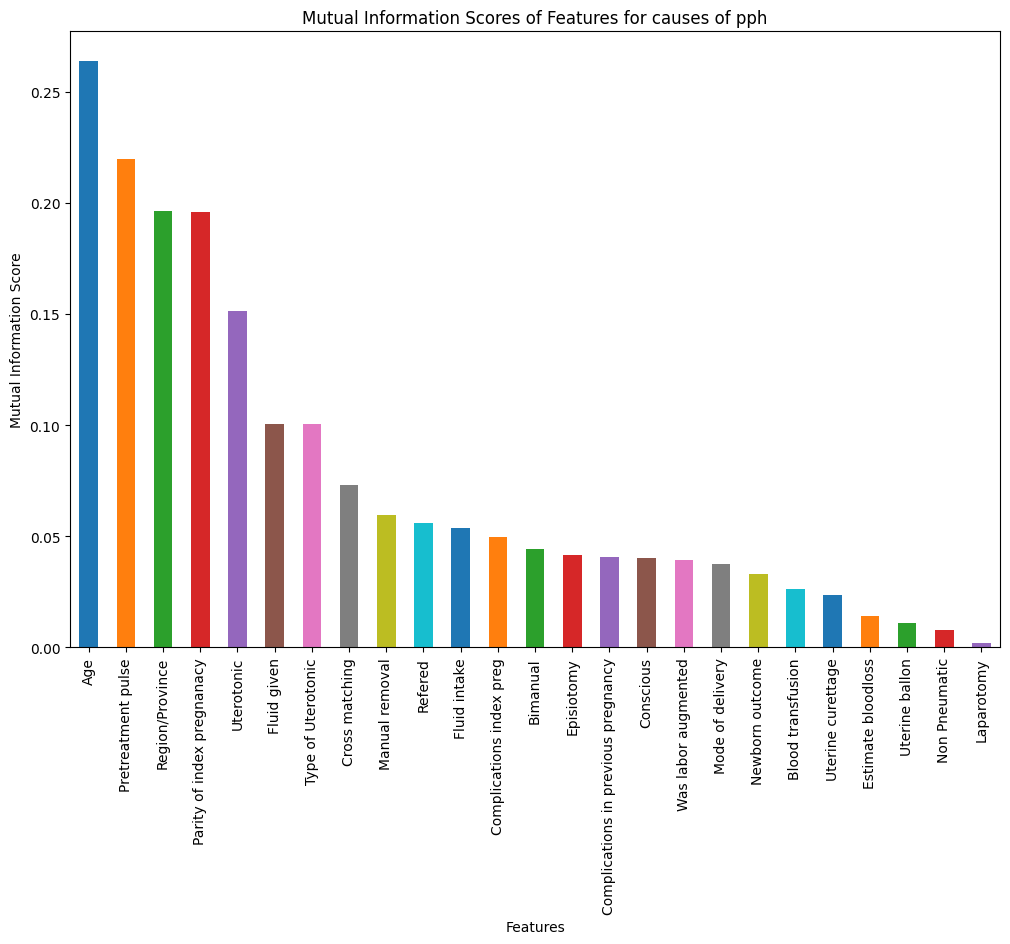

In [19]:
# Plot the sorted Series with different color palettes
palettes = sns.color_palette('tab10', n_colors=len(mi_sorted))
plt.figure(figsize=(12, 8))
mi_sorted.plot(kind='bar', color=palettes)
plt.title('Mutual Information Scores of Features for causes of pph')
plt.xlabel('Features')
plt.ylabel('Mutual Information Score')
plt.xticks(rotation=90)
plt.show()

# Using different classifier models 

## Random Forest Classifier

In [20]:
# Initialize the RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=200, random_state=42)

# Train the model on the standardized training data
rf_clf.fit(X_train, y_train)

# Predict on the validation set
y_val_pred = rf_clf.predict(X_val)

# Evaluate the model on the validation set
val_accuracy = accuracy_score(y_val, y_val_pred)
val_report = classification_report(y_val, y_val_pred)

print(f'Validation Accuracy: {val_accuracy:.4f}')
print('Validation Classification Report:')
print(val_report)

# Optionally, evaluate the model on the test set
y_test_pred = rf_clf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_report = classification_report(y_test, y_test_pred)

print(f'Test Accuracy: {test_accuracy:.4f}')
print('Test Classification Report:')
print(test_report)

Validation Accuracy: 0.6503
Validation Classification Report:
              precision    recall  f1-score   support

         1.0       0.46      0.35      0.40       549
         2.0       0.75      0.63      0.68       548
         3.0       0.48      0.68      0.56       528
         4.0       0.95      0.96      0.95       531

    accuracy                           0.65      2156
   macro avg       0.66      0.65      0.65      2156
weighted avg       0.66      0.65      0.65      2156

Test Accuracy: 0.6690
Test Classification Report:
              precision    recall  f1-score   support

         1.0       0.48      0.38      0.43       530
         2.0       0.76      0.67      0.71       549
         3.0       0.54      0.67      0.60       550
         4.0       0.91      0.95      0.93       528

    accuracy                           0.67      2157
   macro avg       0.67      0.67      0.67      2157
weighted avg       0.67      0.67      0.66      2157



In [21]:
# Define class names
class_names = ['Uterine atony', 'Trauma', 'Retained placenta', 'Clotting disorder']

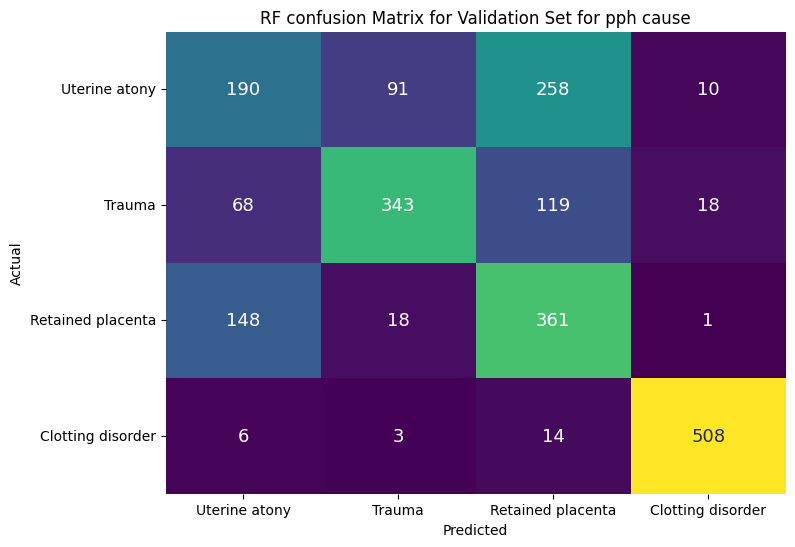

In [22]:
# Calculate the confusion matrix for the validation set
val_cm = confusion_matrix(y_val, y_val_pred)

# Calculate the confusion matrix for the test set
test_cm = confusion_matrix(y_test, y_test_pred)

# Plot the confusion matrix for the validation set
plt.figure(figsize=(8, 6))
sns.heatmap(val_cm, annot=True, fmt='d', cmap="viridis", cbar=False,
            xticklabels=class_names, yticklabels=class_names, annot_kws={"size": 13})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('RF confusion Matrix for Validation Set for pph cause')
plt.show()

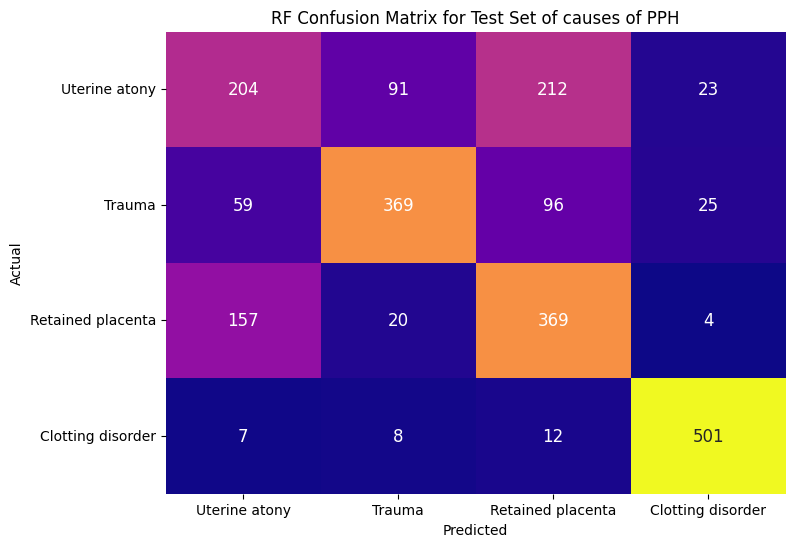

In [23]:
# Plot the confusion matrix for the test set
plt.figure(figsize=(8, 6))
sns.heatmap(test_cm, annot=True, fmt='d', cmap="plasma", cbar=False,
            xticklabels=class_names, yticklabels=class_names, annot_kws={"size": 12})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('RF Confusion Matrix for Test Set of causes of PPH')
plt.show()

## Binarize the true labels for multi-class ROC for random forest

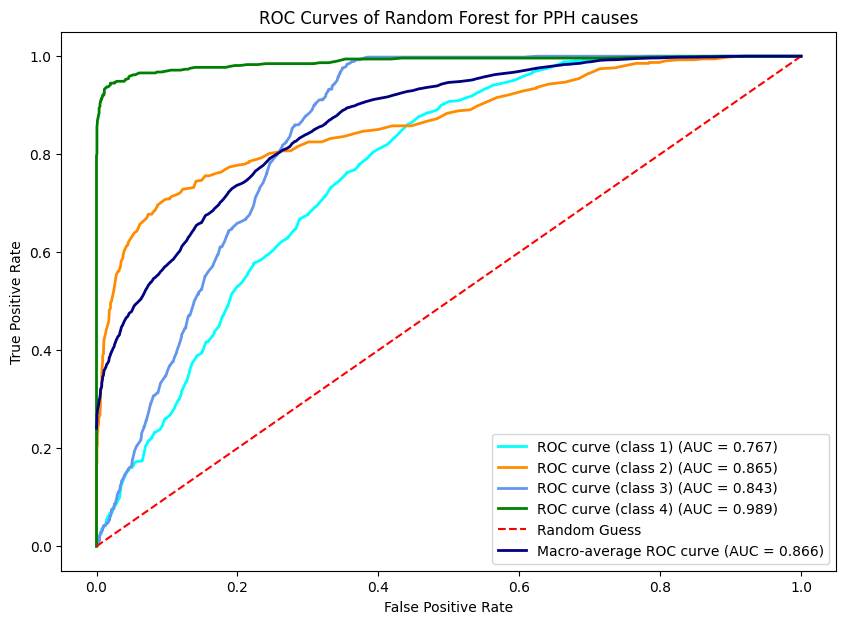

In [24]:
classes = [1, 2, 3, 4]

# Predict probabilities for each class on the validation set
y_score = rf_clf.predict_proba(X_test)

# Binarize the true labels for multi-class ROC
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and ROC area for each class
plt.figure(figsize=(10, 7))
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])
for i, color in zip(range(len(classes)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve (class {classes[i]}) (AUC = {roc_auc[i]:.3f})')

# Plot random guess line
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guess')

# Calculate and plot the macro-average ROC curve and AUC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(classes))]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(classes)):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= len(classes)
macro_auc = auc(all_fpr, mean_tpr)

plt.plot(all_fpr, mean_tpr, color='navy', linestyle='-', linewidth=2,
         label=f'Macro-average ROC curve (AUC = {macro_auc:.3f})')

# Set labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves of Random Forest for PPH causes')
plt.legend(loc='lower right')

# Show the plot
plt.show()

## Decision Tree Classifier model

In [25]:
# Train Decision Tree classifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

# Predict on the validation set
y_val_pred = dt.predict(X_val)

# Evaluate the model on the validation set
val_accuracy = accuracy_score(y_val, y_val_pred)
val_report = classification_report(y_val, y_val_pred)

print(f'Validation Accuracy: {val_accuracy:.4f}')
print('Validation Classification Report:')
print(val_report)

# Optionally, evaluate the model on the test set
y_test_pred = dt.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_report = classification_report(y_test, y_test_pred)

print(f'Test Accuracy: {test_accuracy:.4f}')
print('Test Classification Report:')
print(test_report)

Validation Accuracy: 0.5510
Validation Classification Report:
              precision    recall  f1-score   support

         1.0       0.37      0.35      0.36       549
         2.0       0.52      0.55      0.54       548
         3.0       0.46      0.46      0.46       528
         4.0       0.85      0.85      0.85       531

    accuracy                           0.55      2156
   macro avg       0.55      0.55      0.55      2156
weighted avg       0.55      0.55      0.55      2156

Test Accuracy: 0.5563
Test Classification Report:
              precision    recall  f1-score   support

         1.0       0.38      0.36      0.37       530
         2.0       0.53      0.54      0.54       549
         3.0       0.48      0.47      0.47       550
         4.0       0.82      0.86      0.84       528

    accuracy                           0.56      2157
   macro avg       0.55      0.56      0.55      2157
weighted avg       0.55      0.56      0.55      2157



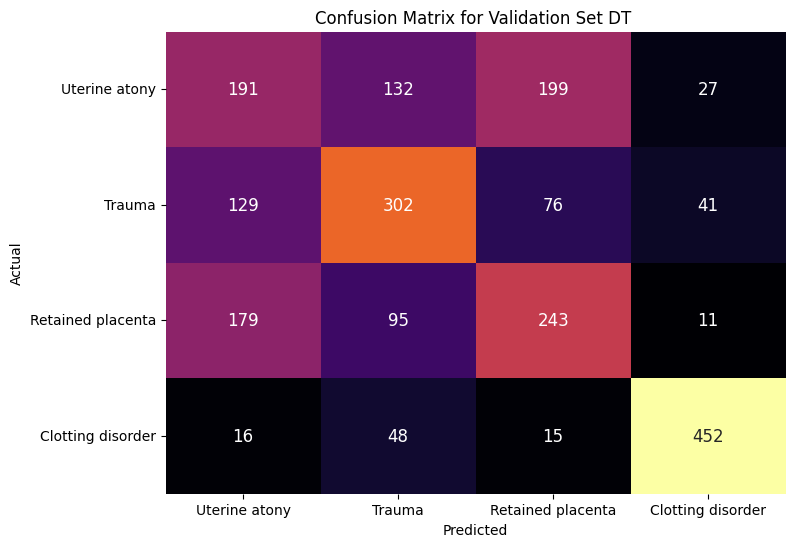

In [26]:
# Calculate the confusion matrix for the validation set
val_cm = confusion_matrix(y_val, y_val_pred)

# Calculate the confusion matrix for the test set
test_cm = confusion_matrix(y_test, y_test_pred)

# Plot the confusion matrix for the validation set
plt.figure(figsize=(8,6))
sns.heatmap(val_cm, annot=True, fmt='d', cmap="inferno", cbar=False,
            xticklabels=class_names, yticklabels=class_names, annot_kws={"size": 12})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Validation Set DT ')
plt.show()

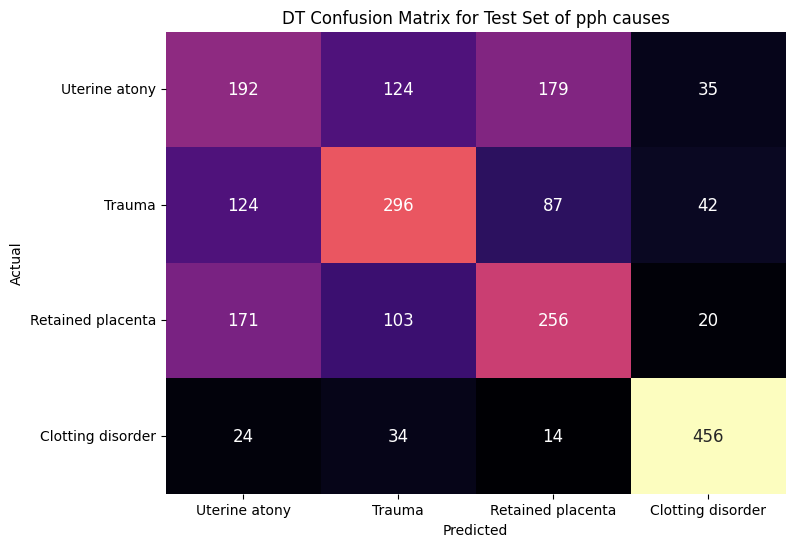

In [27]:
# Plot the confusion matrix for the test set
plt.figure(figsize=(8, 6))
sns.heatmap(test_cm, annot=True, fmt='d', cmap="magma", cbar=False,
            xticklabels=class_names, yticklabels=class_names, annot_kws={"size": 12})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('DT Confusion Matrix for Test Set of pph causes')
plt.show()

## ROC curve for Decision Tree Classifier  

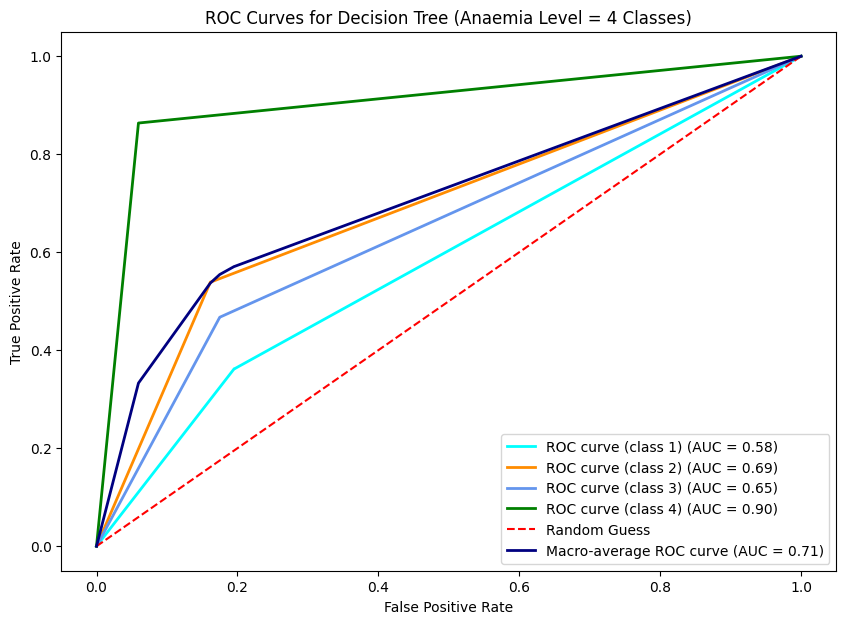

In [28]:
# Predict probabilities for each class on the test set
y_score = dt.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
plt.figure(figsize=(10, 7))
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):  # There are 4 classes (1, 2, 3, 4)
    # Binarize the true labels for class i
    y_test_bin = label_binarize(y_test, classes=[1, 2, 3, 4])[:, i]
    # Compute ROC curve and ROC area
    fpr[i], tpr[i], _ = roc_curve(y_test_bin, y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])
for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve (class {i+1}) (AUC = {roc_auc[i]:.2f})')

# Plot random guess line
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guess')

# Calculate and plot the macro-average ROC curve and AUC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(classes))]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(classes)):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= len(classes)
macro_auc = auc(all_fpr, mean_tpr)

plt.plot(all_fpr, mean_tpr, color='navy', linestyle='-', linewidth=2,
         label=f'Macro-average ROC curve (AUC = {macro_auc:.2f})')

# Set labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Decision Tree (Anaemia Level = 4 Classes)')
plt.legend(loc='lower right')

# Show the plot
plt.show()

## Gradient Boosting Classifier

In [29]:
from sklearn.ensemble import GradientBoostingClassifier


# Initialize the GradientBoostingClassifier
gb_clf = GradientBoostingClassifier(n_estimators=300, random_state=42)

# Train the model on the standardized training data
gb_clf.fit(X_train, y_train)

# Predict on the validation set
y_val_pred = gb_clf.predict(X_val)

# Evaluate the model on the validation set
val_accuracy = accuracy_score(y_val, y_val_pred)
val_report = classification_report(y_val, y_val_pred)

print(f'Gradient Boosting - Validation Accuracy: {val_accuracy:.4f}')
print('Gradient Boosting - Validation Classification Report:')
print(val_report)

# Optionally, evaluate the model on the test set
y_test_pred = gb_clf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_report = classification_report(y_test, y_test_pred)

print(f'Gradient Boosting - Test Accuracy: {test_accuracy:.4f}')
print('Gradient Boosting - Test Classification Report:')
print(test_report)

Gradient Boosting - Validation Accuracy: 0.6058
Gradient Boosting - Validation Classification Report:
              precision    recall  f1-score   support

         1.0       0.46      0.26      0.33       549
         2.0       0.72      0.47      0.56       548
         3.0       0.47      0.79      0.59       528
         4.0       0.83      0.92      0.87       531

    accuracy                           0.61      2156
   macro avg       0.62      0.61      0.59      2156
weighted avg       0.62      0.61      0.59      2156

Gradient Boosting - Test Accuracy: 0.6027
Gradient Boosting - Test Classification Report:
              precision    recall  f1-score   support

         1.0       0.40      0.27      0.33       530
         2.0       0.68      0.48      0.56       549
         3.0       0.50      0.73      0.60       550
         4.0       0.80      0.92      0.86       528

    accuracy                           0.60      2157
   macro avg       0.60      0.60      0.59    

## Roc curve for Gradient Boosting Classifier

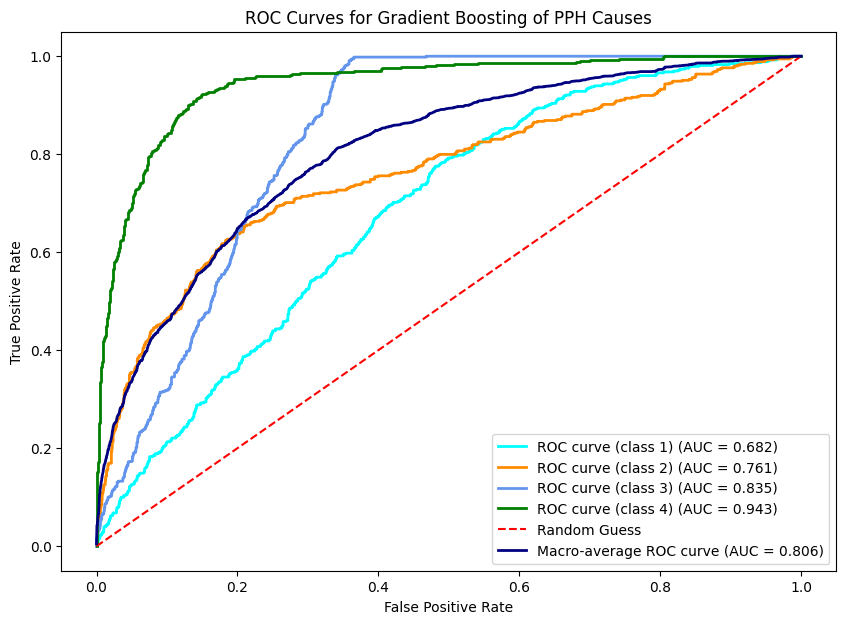

In [30]:
# Train the Gradient Boosting Classifier
gboost_clf = GradientBoostingClassifier(n_estimators=100, random_state=42)
gboost_clf.fit(X_train, y_train)

# Predict probabilities for each class on the test set
y_score = gboost_clf.predict_proba(X_test)

# Binarize the true labels for multi-class ROC (adjust for 4 classes)
classes = [1, 2, 3, 4]
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and ROC area for each class
plt.figure(figsize=(10, 7))
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])
for i, color in zip(range(len(classes)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve (class {classes[i]}) (AUC = {roc_auc[i]:.3f})')

# Plot random guess line
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guess')

# Calculate and plot the macro-average ROC curve and AUC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(classes))]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(classes)):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= len(classes)
macro_auc = auc(all_fpr, mean_tpr)

plt.plot(all_fpr, mean_tpr, color='navy', linestyle='-', linewidth=2,
         label=f'Macro-average ROC curve (AUC = {macro_auc:.3f})')

# Set labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Gradient Boosting of PPH Causes')
plt.legend(loc='lower right')

# Show the plot
plt.show()

## Multinomial Logistic Regression 

In [32]:
from sklearn.linear_model import LogisticRegression

# Train Multinomial Logistic Regression classifier
logreg = LogisticRegression(random_state=42, max_iter=200000, multi_class='multinomial', solver='lbfgs')
logreg.fit(X_train, y_train)

# Predict on the validation set
y_val_pred = logreg.predict(X_val)

# Evaluate the model on the validation set
val_accuracy = accuracy_score(y_val, y_val_pred)
val_report = classification_report(y_val, y_val_pred)

print(f'Multinomial Logistic Regression - Validation Accuracy: {val_accuracy:.4f}')
print('Multinomial Logistic Regression - Validation Classification Report:')
print(val_report)

# Optionally, evaluate the model on the test set
y_test_pred = logreg.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_report = classification_report(y_test, y_test_pred)

print(f'Multinomial Logistic Regression - Test Accuracy: {test_accuracy:.4f}')
print('Multinomial Logistic Regression - Test Classification Report:')
print(test_report)

Multinomial Logistic Regression - Validation Accuracy: 0.3015
Multinomial Logistic Regression - Validation Classification Report:
              precision    recall  f1-score   support

         1.0       0.29      0.23      0.26       549
         2.0       0.26      0.27      0.26       548
         3.0       0.30      0.23      0.26       528
         4.0       0.34      0.48      0.40       531

    accuracy                           0.30      2156
   macro avg       0.30      0.30      0.30      2156
weighted avg       0.30      0.30      0.29      2156

Multinomial Logistic Regression - Test Accuracy: 0.3018
Multinomial Logistic Regression - Test Classification Report:
              precision    recall  f1-score   support

         1.0       0.26      0.22      0.23       530
         2.0       0.26      0.26      0.26       549
         3.0       0.34      0.26      0.30       550
         4.0       0.34      0.48      0.40       528

    accuracy                           0.30  

## xgboost classifier model

In [33]:
import xgboost as xgb

# Adjust class labels to start from 0
y_train = (y_train - 1).astype(int)
y_val = (y_val - 1).astype(int)
y_test = (y_test - 1).astype(int)

# Train XGBoost classifier
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Predict on the validation set
y_val_pred = xgb_model.predict(X_val)

# Evaluate the model on the validation set
val_accuracy = accuracy_score(y_val, y_val_pred)
val_report = classification_report(y_val, y_val_pred)

print(f'XGBoost - Validation Accuracy: {val_accuracy:.4f}')
print('XGBoost - Validation Classification Report:')
print(val_report)

# Optionally, evaluate the model on the test set
y_test_pred = xgb_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_report = classification_report(y_test, y_test_pred)

print(f'XGBoost - Test Accuracy: {test_accuracy:.4f}')
print('XGBoost - Test Classification Report:')
print(test_report)

XGBoost - Validation Accuracy: 0.6433
XGBoost - Validation Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.33      0.39       549
           1       0.76      0.59      0.67       548
           2       0.48      0.72      0.57       528
           3       0.91      0.95      0.93       531

    accuracy                           0.64      2156
   macro avg       0.65      0.65      0.64      2156
weighted avg       0.65      0.64      0.64      2156

XGBoost - Test Accuracy: 0.6523
XGBoost - Test Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.38      0.42       530
           1       0.76      0.62      0.68       549
           2       0.51      0.67      0.58       550
           3       0.90      0.95      0.92       528

    accuracy                           0.65      2157
   macro avg       0.66      0.65      0.65      2157
weighted avg       0.66      0.65

## KNN Classifier Model

In [34]:
from sklearn.neighbors import KNeighborsClassifier

# Train KNN classifier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

# Predict on the validation set
y_val_pred = knn.predict(X_val)

# Evaluate the model on the validation set
val_accuracy = accuracy_score(y_val, y_val_pred)
val_report = classification_report(y_val, y_val_pred)

print(f'KNN - Validation Accuracy: {val_accuracy:.4f}')
print('KNN - Validation Classification Report:')
print(val_report)

# Optionally, evaluate the model on the test set
y_test_pred = knn.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_report = classification_report(y_test, y_test_pred)

print(f'KNN - Test Accuracy: {test_accuracy:.4f}')
print('KNN - Test Classification Report:')
print(test_report)


KNN - Validation Accuracy: 0.5737
KNN - Validation Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.48      0.48       549
           1       0.54      0.69      0.61       548
           2       0.41      0.20      0.27       528
           3       0.76      0.92      0.83       531

    accuracy                           0.57      2156
   macro avg       0.55      0.57      0.55      2156
weighted avg       0.55      0.57      0.55      2156

KNN - Test Accuracy: 0.5976
KNN - Test Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.56      0.51       530
           1       0.56      0.72      0.63       549
           2       0.49      0.20      0.29       550
           3       0.80      0.93      0.86       528

    accuracy                           0.60      2157
   macro avg       0.58      0.60      0.57      2157
weighted avg       0.58      0.60      0.57      

## Performance Comparision of different Models 

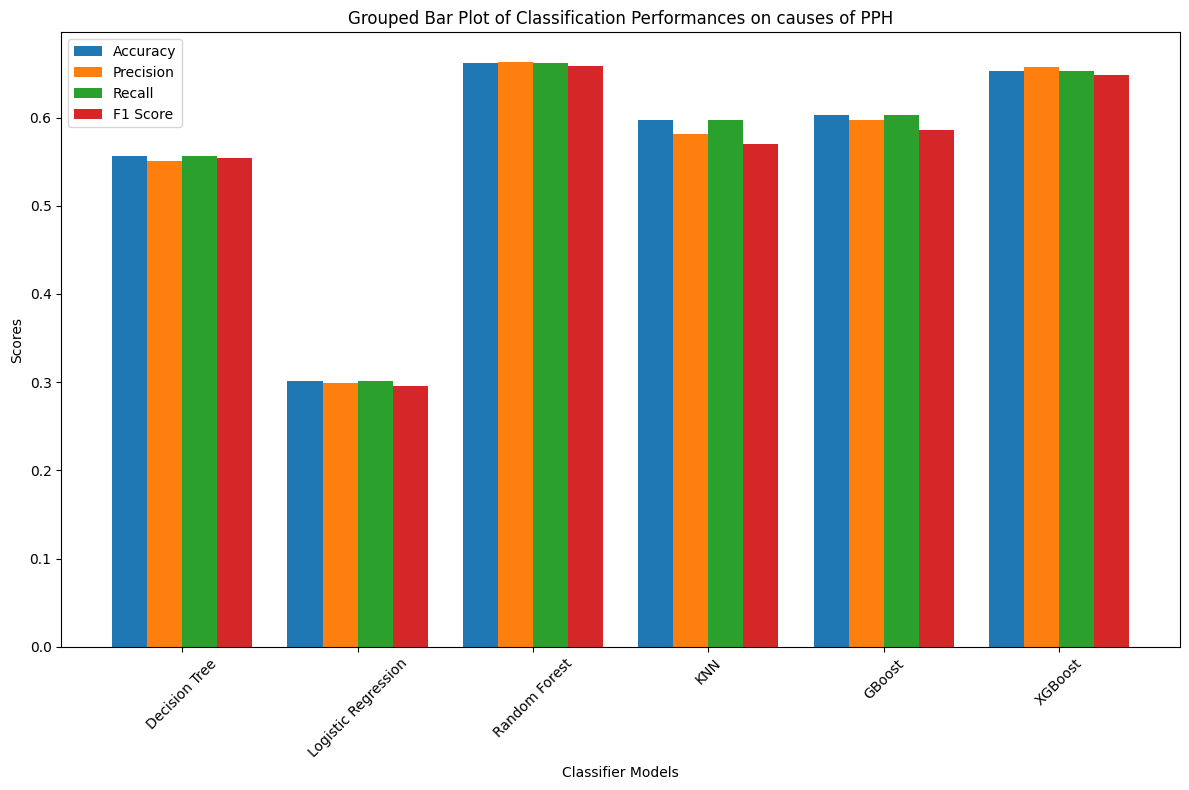

In [35]:
# List of models to evaluate
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=200000, multi_class='multinomial', solver='lbfgs'),
    'Random Forest': RandomForestClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    "GBoost" : GradientBoostingClassifier(n_estimators=300, random_state=42), 
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# Initialize a dictionary to store performance metrics
performance_metrics = {
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': []
}

# Iterate over each model to train, predict, and collect metrics
for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred, average='weighted')
    recall = recall_score(y_test, y_test_pred, average='weighted')
    f1 = f1_score(y_test, y_test_pred, average='weighted')
    
    # Store metrics
    performance_metrics['Accuracy'].append(accuracy)
    performance_metrics['Precision'].append(precision)
    performance_metrics['Recall'].append(recall)
    performance_metrics['F1 Score'].append(f1)

# Convert to numpy array for plotting
metrics_array = np.array([performance_metrics['Accuracy'],
                          performance_metrics['Precision'],
                          performance_metrics['Recall'],
                          performance_metrics['F1 Score']])

# Create the grouped bar plot
model_names = list(models.keys())
metric_names = list(performance_metrics.keys())
n_metrics = len(metric_names)
n_models = len(model_names)

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Define bar width and positions
bar_width = 0.2
indices = np.arange(n_models)

# Plot bars for each metric
for i, metric in enumerate(metric_names):
    ax.bar(indices + i * bar_width, metrics_array[i], bar_width, label=metric)

# Add labels and title
ax.set_xlabel('Classifier Models')
ax.set_ylabel('Scores')
ax.set_title('Grouped Bar Plot of Classification Performances on causes of PPH')
ax.set_xticks(indices + bar_width * (n_metrics - 1) / 2)
ax.set_xticklabels(model_names, rotation=45)
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

## LSTM Model

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Reshape the data to fit LSTM input requirements
# Assuming X_train, X_val, X_test are 2D arrays and you want 1 time step
X_train_lstm = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val_lstm = X_val.values.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test_lstm = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Initialize the LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(32))
model.add(Dropout(0.5))
model.add(Dense(len(np.unique(y_train)), activation='softmax'))  # Adjust output layer for number of classes

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_lstm, y_train, epochs=20, batch_size=5, validation_data=(X_val_lstm, y_val))

# Predict on the validation set
y_val_pred_probs = model.predict(X_val_lstm)
y_val_pred = np.argmax(y_val_pred_probs, axis=1)

# Evaluate the model on the validation set
val_accuracy = accuracy_score(y_val, y_val_pred)
val_report = classification_report(y_val, y_val_pred)

print(f'LSTM - Validation Accuracy: {val_accuracy:.4f}')
print('LSTM - Validation Classification Report:')
print(val_report)

# Optionally, predict on the test set
y_test_pred_probs = model.predict(X_test_lstm)
y_test_pred = np.argmax(y_test_pred_probs, axis=1)

# Evaluate the model on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_report = classification_report(y_test, y_test_pred)

print(f'LSTM - Test Accuracy: {test_accuracy:.4f}')
print('LSTM - Test Classification Report:')
print(test_report)

Epoch 1/20
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.2589 - loss: 1.3916 - val_accuracy: 0.2477 - val_loss: 1.3854
Epoch 2/20
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.2508 - loss: 1.3873 - val_accuracy: 0.2449 - val_loss: 1.3847
Epoch 3/20
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.2620 - loss: 1.3838 - val_accuracy: 0.2607 - val_loss: 1.3817
Epoch 4/20
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.2541 - loss: 1.3842 - val_accuracy: 0.2481 - val_loss: 1.3834
Epoch 5/20
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.2629 - loss: 1.3813 - val_accuracy: 0.2607 - val_loss: 1.3813
Epoch 6/20
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.2529 - loss: 1.3815 - val_accuracy: 0.2458 - val_loss: 1.3817
Epoch 7/20
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.2471 - loss: 1.3814 - val_accuracy: 0.2454 - val_loss: 1.3816
Epoch 8/20
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.2589 - loss: 1.3822 - 